## Install Semantic Link Labs

Find more information in their GitHub Repo:
https://github.com/microsoft/semantic-link-labs

In [1]:
# Install semantic link labs
%pip install semantic-link-labs

StatementMeta(, 252b3750-5fb9-45d0-8be0-b0ff9ac6f0cc, 8, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.5/682.5 kB 18.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 15.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [2]:
import sempy_labs as labs
from sempy_labs import lakehouse as lake
from delta.tables import *
from pyspark.sql.functions import *
from datetime import datetime, timedelta
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType

DEBUG = False

StatementMeta(, 252b3750-5fb9-45d0-8be0-b0ff9ac6f0cc, 10, Finished, Available, Finished)

## Several functions for working with Lakehouse

1. Optimize lakehouse tables
2. Vacuum lakehouse tables
3. Create, delete, and view shortcuts
4. Analyze delta tables for Direct Lake semantic models using Delta Analyzer

In [3]:
df_test = lake.get_lakehouse_tables()
display(df_test)


StatementMeta(, 252b3750-5fb9-45d0-8be0-b0ff9ac6f0cc, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 4df72a54-b032-4ef2-877f-182cf7d62fee)

# Create function to maintain your Lakehouse
#### 1. analyze tables 
        a) file size
        b) # of files  
        c) last OPTIMIZE
        d) last VACUUM

In [4]:

def analyze_delta_maintenance(table_paths):
    """
    Analyzes Delta tables for maintenance needs by checking:
    1. Number of files per partition
    2. File sizes
    3. Last OPTIMIZE operation
    4. Last VACUUM operation
    
    Parameters:
    table_paths: List of paths to Delta tables
    
    Returns:
    pandas.DataFrame: Analysis results for each table
    """
    #display(table_paths)
    schema = StructType([
                StructField('table_name', StringType(), True),
                StructField('table_path', StringType(), True),
                StructField('num_files', IntegerType(), True),
                StructField('avg_file_size_mb', FloatType(), True),
                StructField('total_table_size_mb', FloatType(), True),
                StructField('last_optimize', StringType(), True),
                StructField('last_vacuum', StringType(), True),
                StructField('days_since_optimize', IntegerType(), True),
                StructField('days_since_vacuum', IntegerType(), True),
                StructField('needs_optimize', BooleanType(), True),
                StructField('needs_vacuum', BooleanType(), True)
            ])
    
    results = []
    cnt = 0
    for table_path, table_name in zip(table_paths['Location'], table_paths['Table Name']):
        
        try:
            if DEBUG: print(cnt)

            # Load Delta table
            display(table_name)
            delta_table = DeltaTable.forPath(path=table_path, sparkSession=spark)

            # Get history
            if DEBUG: print('get history')
            history = delta_table.history()
            
            # Get latest OPTIMIZE operation
            if DEBUG: print('last optimize')
            last_optimize = history.filter("operation = 'OPTIMIZE'") \
                .select(max('timestamp').alias('last_optimize')) \
                .collect()[0]['last_optimize']
            
            # Get latest VACUUM operation
            if DEBUG: print('last vacuum')
            last_vacuum = history.filter("operation = 'VACUUM END'") \
                .select(max('timestamp').alias('last_vacuum')) \
                .collect()[0]['last_vacuum']
            
            # Analyze files
            if DEBUG: print('analyze files')
            files_df = spark.sql(f"DESCRIBE DETAIL '{table_path}'")
            num_files = int(files_df.select('numFiles').collect()[0]['numFiles'])
            
            # Get size statistics
            size_bytes = float(files_df.select('sizeInBytes').collect()[0]['sizeInBytes'])
            
            # Calculate average file size
            avg_file_size_mb = float(size_bytes / num_files) / (1024 * 1024) if num_files > 0 else 0.0
            
            if DEBUG: print(avg_file_size_mb) 

            total_table_size_mb = float(size_bytes) / (1024 * 1024)
            
            if DEBUG: print(total_table_size_mb)

            # Calculate days since operations
            current_time = datetime.now()
            days_since_optimize = None
            days_since_vacuum = None
            
            if last_optimize is not None:
                days_since_optimize = (current_time - last_optimize).days
            else:
                None
                    
            if last_vacuum is not None:
                days_since_vacuum = (current_time - last_vacuum).days
            else:
                None
            
            # Determine if maintenance is needed
            needs_optimize = bool(last_optimize is None or (days_since_optimize is not None and days_since_optimize > 7) or num_files > 50 or avg_file_size_mb < 128)
            
            needs_vacuum = bool(last_vacuum is None or (days_since_vacuum is not None and days_since_vacuum > 30))
            
            results.append({
                'table_name': table_name if table_name else "",
                'table_path': str(table_path) if table_path else "",
                'num_files': int(num_files) if num_files is not None else 0,
                'avg_file_size_mb': avg_file_size_mb if avg_file_size_mb is not None else 0.0,
                'total_table_size_mb': total_table_size_mb if total_table_size_mb is not None else 0.0,
                'last_optimize': str(last_optimize) if last_optimize is not None else "",
                'last_vacuum': str(last_vacuum) if last_vacuum is not None else "",
                'days_since_optimize': int(days_since_optimize) if days_since_optimize is not None else None,
                'days_since_vacuum': int(days_since_vacuum) if days_since_vacuum is not None else None,
                'needs_optimize': needs_optimize,
                'needs_vacuum': needs_vacuum
            })
            
            #display(results)
            cnt = cnt + 1
        except Exception as e:
            print(f"Error analyzing table {table_path}: {str(e)}")
            
    return spark.createDataFrame(results, schema=schema)



StatementMeta(, 252b3750-5fb9-45d0-8be0-b0ff9ac6f0cc, 12, Finished, Available, Finished)

# Let's check our Lakehouse!

In [5]:
# read all tables
df = lake.get_lakehouse_tables()

#only include tables that are delta format
df_filtered = df[df['Format'] == 'delta']

# display(df_filtered)

analyzed_tables = analyze_delta_maintenance(df_filtered)

display(analyzed_tables)





StatementMeta(, 252b3750-5fb9-45d0-8be0-b0ff9ac6f0cc, 13, Finished, Available, Finished)

'AgeGenderBuyMatrix'

'CategorySchedule'

'TopCategory'

'FactualProduct'

'TimeSlice'

'Customer'

'SeasonalBuys'

'SalesDetail'

'SalesHeader'

'Household'

'Category'

SynapseWidget(Synapse.DataFrame, 103e4cf7-50cf-46d2-9b70-1c8115ea06b6)

# Let's optimize if needed

In [6]:
table_list = []

for row in analyzed_tables.rdd.collect():
    if row.needs_optimize:
        table_name = row.table_name
        table_list.append(table_name)

# Optimize all tables that need optimization
if table_list:
    lake.optimize_lakehouse_tables(tables=table_list)

StatementMeta(, 2fd97d05-3f90-4036-ada0-4ccae024a8a9, 14, Finished, Available, Finished)

0it [00:00, ?it/s]

StatementMeta(, 2fd97d05-3f90-4036-ada0-4ccae024a8a9, 15, Finished, Available, Finished)

### Let's check after optimize

In [6]:
analyzed_tables_after_optimize = analyze_delta_maintenance(df_filtered)

display(analyzed_tables_after_optimize)

StatementMeta(, 205535af-7058-46b4-9ec7-fc83a91c1442, 15, Finished, Available, Finished)

'AgeGenderBuyMatrix'

'SalesHeader'

'Customer'

'TopCategory'

'Household'

'SalesDetail'

'CategorySchedule'

'Category'

'FactualProduct'

'TimeSlice'

'SeasonalBuys'

SynapseWidget(Synapse.DataFrame, aa5a8929-1559-482c-9e3e-4bb3fcbf6736)

# Let's do some vacuuming 
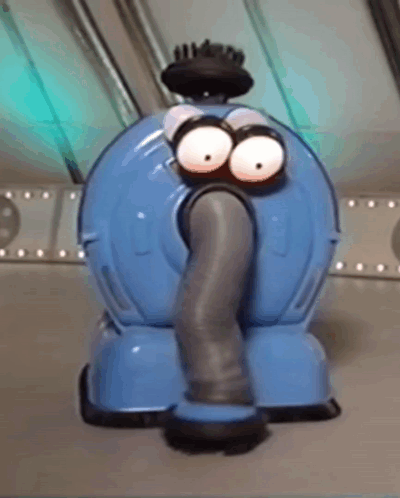

In [ ]:
table_list = []

for row in analyzed_tables.rdd.collect():
    table_name = row.table_name
    
    if row.needs_vacuum:
        table_list.append(table_name)

# Optimize all tables that need optimization
if table_list:
    lake.vacuum_lakehouse_tables(tables=table_list)

In [28]:
analyzed_tables_after_vacuum = analyze_delta_maintenance(df)

display(analyzed_tables_after_vacuum)

StatementMeta(, 8dd813e9-365b-44ed-b0cb-a9c32cdfff6a, 38, Finished, Available, Finished)

'AgeGenderBuyMatrix'

'SeasonalBuys'

'SalesHeader'

'Customer'

'TopCategory'

'Household'

'FactualProduct'

'TimeSlice'

'SalesDetail'

'CategorySchedule'

'Category'

SynapseWidget(Synapse.DataFrame, dd50c152-aecb-4152-8382-72afe9249159)

In [26]:
from delta.tables import *

delta_table = DeltaTable.forPath(path='abfss://12def05c-f1f7-4fb8-82bd-e01930ec01fb@onelake.dfs.fabric.microsoft.com/b05bc2b7-f220-4ab1-be94-e3ca1d28b4a7/Tables/Customer', sparkSession=spark)           

# Get history
print('get history')
history = delta_table.history()
display(history)

StatementMeta(, 8dd813e9-365b-44ed-b0cb-a9c32cdfff6a, 36, Finished, Available, Finished)

get history


SynapseWidget(Synapse.DataFrame, a6d62288-5b3b-4f6b-b9f7-affebf7758b7)